##A notebook to explore the Wikipedia edit history and how a recommender system may work on this data

In [168]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
import pandas as pd
import numpy as np
import sys
import itertools
from math import sqrt
from operator import add
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

In [13]:
data_path = "hdfs:///datasets/wikipedia/enwiki-latest-pages-meta-history1.xml-p000000010p000002807.json.gz"

In [14]:
#read in the data
wiki_edits = sqlCtx.read.json(data_path)

In [188]:
#quick view of the data we are working with
wiki_edits.take(5)

[Row(article_id=10, article_namespace=0, article_title=u'AccessibleComputing', comment=u'*', minor=False, parent_id=None, redirect_target=u'Computer accessibility', revision_id=233192, timestamp=u'2001-01-21T02:12:21Z', user_id=99, user_name=u'RoseParks'),
 Row(article_id=10, article_namespace=0, article_title=u'AccessibleComputing', comment=u'Automated conversion', minor=True, parent_id=233192, redirect_target=u'Computer accessibility', revision_id=862220, timestamp=u'2002-02-25T15:43:11Z', user_id=0, user_name=u'Conversion script'),
 Row(article_id=10, article_namespace=0, article_title=u'AccessibleComputing', comment=u'Fixing redirect', minor=True, parent_id=862220, redirect_target=u'Computer accessibility', revision_id=15898945, timestamp=u'2003-04-25T22:18:38Z', user_id=7543, user_name=u'Ams80'),
 Row(article_id=10, article_namespace=0, article_title=u'AccessibleComputing', comment=u'fix double redirect', minor=True, parent_id=15898945, redirect_target=u'Computer accessibility', r

In [16]:
wiki_edits.printSchema()

root
 |-- article_id: long (nullable = true)
 |-- article_namespace: long (nullable = true)
 |-- article_title: string (nullable = true)
 |-- comment: string (nullable = true)
 |-- minor: boolean (nullable = true)
 |-- parent_id: long (nullable = true)
 |-- redirect_target: string (nullable = true)
 |-- revision_id: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_name: string (nullable = true)



In [17]:
wiki_edits.registerTempTable('wiki')

In [21]:
#simple query to check that the IP addresses are those without a user_id
sqlCtx.sql("select * from wiki where user_id is null").take(10)

[Row(article_id=10, article_namespace=0, article_title=u'AccessibleComputing', comment=None, minor=False, parent_id=133452289, redirect_target=u'Computer accessibility', revision_id=381200179, timestamp=u'2010-08-26T22:23:51Z', user_id=None, user_name=u'76.28.186.133'),
 Row(article_id=12, article_namespace=0, article_title=u'Anarchism', comment=u'*', minor=False, parent_id=18201, redirect_target=None, revision_id=19746, timestamp=u'2002-02-25T15:43:11Z', user_id=None, user_name=u'140.232.153.45'),
 Row(article_id=12, article_namespace=0, article_title=u'Anarchism', comment=u'*', minor=False, parent_id=19746, redirect_target=None, revision_id=19749, timestamp=u'2002-02-27T17:34:09Z', user_id=None, user_name=u'24.188.31.147'),
 Row(article_id=12, article_namespace=0, article_title=u'Anarchism', comment=u'*', minor=False, parent_id=19749, redirect_target=None, revision_id=20514, timestamp=u'2002-02-27T17:36:41Z', user_id=None, user_name=u'24.188.31.147'),
 Row(article_id=12, article_name

In [20]:
#total number of revisions in our file
wiki_edits.count()

1846836

###View the number of articles and revisions a user is making

In [38]:
users = sqlCtx.sql("select user_id, count(1) as rev_count, count(distinct(article_id)) as article_num \
from wiki where user_id is not null group by user_id")

In [39]:
users_local = users.collect()

In [40]:
users_local[:10]

[Row(user_id=2796431, rev_count=1, article_num=1),
 Row(user_id=24532431, rev_count=1, article_num=1),
 Row(user_id=7348231, rev_count=61, article_num=13),
 Row(user_id=10296231, rev_count=1, article_num=1),
 Row(user_id=509431, rev_count=2, article_num=1),
 Row(user_id=3446431, rev_count=1, article_num=1),
 Row(user_id=9041631, rev_count=2, article_num=2),
 Row(user_id=234831, rev_count=1, article_num=1),
 Row(user_id=3996831, rev_count=1, article_num=1),
 Row(user_id=1911631, rev_count=39, article_num=7)]

In [42]:
users_local_df = pd.DataFrame(users_local, columns=["user_id", "rev_count", "article_num"])

In [43]:
users_local_df.head()

,user_id,rev_count,article_num
0,2796431,1,1
1,24532431,1,1
2,7348231,61,13
3,10296231,1,1
4,509431,2,1


In [44]:
print max(users_local_df.rev_count), min(users_local_df.rev_count), np.mean(users_local_df.rev_count)
print max(users_local_df.article_num), min(users_local_df.article_num), np.mean(users_local_df.rev_count)

12424 1 9.33026352853
1755 1 3.47698820068


In [73]:
#count the number of articles represented (even those outside of namespace=0)
sqlCtx.sql("select distinct(article_id) from wiki").count()

1764

In [167]:
#count the number of users represented
sqlCtx.sql("select distinct(user_id) from wiki where user_id is not null").count()

127804

###Prepare training and test data, knowing the MLLib takes in (user, page, rating)
####We will try differeng ways of representing rating and is one of the biggest levers we have

In [183]:
article_raw = sqlCtx.sql("select user_id, article_id, count(1) as article_count from wiki \
where user_id is not null and article_namespace=0 group by user_id, article_id")

In [184]:
#Some users look at a lot of data, this is where the 5 edit ceiling was developed in the data version above
#the code below did not use the .map(lambda (u, a, a_c): (u, a, min(a_c, 5))) code
article_user_local = article_raw.collect()

In [185]:
article_user_local[:10]

[Row(user_id=1601135, article_id=2752, article_count=2),
 Row(user_id=24420788, article_id=791, article_count=1),
 Row(user_id=2377922, article_id=633, article_count=1),
 Row(user_id=7691690, article_id=2017, article_count=1),
 Row(user_id=1395162, article_id=2753, article_count=1),
 Row(user_id=82432, article_id=2563, article_count=9),
 Row(user_id=239201, article_id=2310, article_count=1),
 Row(user_id=433328, article_id=1811, article_count=1),
 Row(user_id=10286712, article_id=803, article_count=1),
 Row(user_id=555420, article_id=1807, article_count=1)]

In [186]:
article_user_df = pd.DataFrame(article_user_local, columns=["user_id", "article", "art_count"])

In [187]:
print min(article_user_df.art_count), max(article_user_df.art_count), np.mean(article_user_df.art_count)

1 1663 2.6445193024


In [140]:
len(article_user_df)

413484

In [149]:
len(article_user_df[article_user_df.art_count>5])

24154

In [150]:
#very small proportion of the users edit a particular article more than 5 times
24154/413484.0*100

5.841580327171063

In [146]:
c = article_user_df[article_user_df.art_count<5]

In [127]:
np.mean(article_user_df.art_count)

2.5951233905060413

(array([ 282993.,   63291.,   23954.,   12109.,       0.,    6983.,
           4469.,    3093.,    2297.,    1703.]),
 array([ 1. ,  1.8,  2.6,  3.4,  4.2,  5. ,  5.8,  6.6,  7.4,  8.2,  9. ]),
 <a list of 10 Patch objects>)

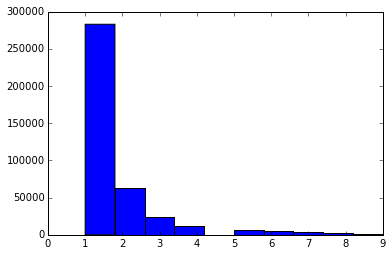

In [148]:
plt.hist(c.art_count)

###Now that the general anatomy of the data is known we can split the data into training and testing

In [169]:
article_user_train = sqlCtx.sql("select user_id, article_id, count(1) as article_count from wiki \
where user_id is not null and article_namespace=0 and timestamp not like '%9Z' group by user_id, article_id")\
.map(lambda (u, a, a_c): (u, a, min(a_c, 5)))

In [170]:
article_user_test = sqlCtx.sql("select user_id, article_id, count(1) as article_count from wiki \
where user_id is not null and article_namespace=0 and timestamp like '%9Z' group by user_id, article_id")\
.map(lambda (u, a, a_c): (u, a, min(a_c, 5)))

In [171]:
print article_user_train.count()
print article_user_test.count()

402133
74324


In [87]:
#checking to see that the split on timestamp is OK
77077/444373.0*100

17.345113226951234

###Now that we have some training and test data we can train and test a model

In [162]:
model = ALS.train(article_user_train, rank = 10, iterations = 5)

In [96]:
##from MovieLensALS.py
def computeRmse(model, data):
    """
    Compute RMSE (Root Mean Squared Error).
    """
    predictions = model.predictAll(data.map(lambda x: (x[0], x[1])))
    predictionsAndRatings = predictions.map(lambda x: ((x[0], x[1]), x[2])) \
      .join(data.map(lambda x: ((x[0], x[1]), x[2]))) \
      .values()
    n = data.count()
    return sqrt(predictionsAndRatings.map(lambda x: (x[0] - x[1]) ** 2).reduce(add) / float(n))

In [90]:
#using the edit count as the "rating"
computeRmse(model, article_user_test)

24.31148553449491

In [163]:
#using the edit count as the "rating" with a ceiling of 5 edits
computeRmse(model, article_user_test)

1.4861927877363568

In [97]:
#using a bollean edited, not edited
#this may be a bit more accurate to if a user will interact with an article or not
computeRmse(model, article_user_test)

0.0767297258759174

In [173]:
predictions = model.predictAll(article_user_test.map(lambda x: (x[0], x[1])))

In [174]:
#View of what the preditions look like
predictions.take(10)

[Rating(user=2164608, product=2100, rating=1.913035174886199),
 Rating(user=110590, product=2100, rating=0.2837415583329478),
 Rating(user=624973, product=2100, rating=5.029465109553854),
 Rating(user=241822, product=2100, rating=0.387948899782942),
 Rating(user=796794, product=2100, rating=1.175344818469397),
 Rating(user=2068487, product=2100, rating=4.135496433629301),
 Rating(user=84632, product=2100, rating=3.9837808506369643),
 Rating(user=18797588, product=2100, rating=1.9758460898082797),
 Rating(user=91088, product=2100, rating=3.5840368351676393),
 Rating(user=231030, product=2100, rating=1.34340893408447)]

In [175]:
predictions.count()

67853

In [176]:
article_user_test.count()

74324

In [182]:
coverage = predictions.count()/float(article_user_test.count())*100
print coverage

91.2935256445
